<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Create-Graphs" data-toc-modified-id="Create-Graphs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create Graphs</a></span><ul class="toc-item"><li><span><a href="#Monthly" data-toc-modified-id="Monthly-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Monthly</a></span></li></ul></li></ul></div>

In [1]:
import json
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pickle
import copy
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
def parse(path):
    with open(path, 'rb') as file:
        for l in file:
            yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## Preprocessing

In [6]:
df = getDF('reviews_Books_5.json')

In [7]:
df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,"[0, 0]",Spiritually and mentally inspiring! A book tha...,5.0,Wonderful!,1355616000,"12 16, 2012"
1,A2S166WSCFIFP5,000100039X,"adead_poet@hotmail.com ""adead_poet@hotmail.com""","[0, 2]",This is one my must have books. It is a master...,5.0,close to god,1071100800,"12 11, 2003"
2,A1BM81XB4QHOA3,000100039X,"Ahoro Blethends ""Seriously""","[0, 0]",This book provides a reflection that you can a...,5.0,Must Read for Life Afficianados,1390003200,"01 18, 2014"
3,A1MOSTXNIO5MPJ,000100039X,Alan Krug,"[0, 0]",I first read THE PROPHET in college back in th...,5.0,Timeless for every good and bad time in your l...,1317081600,"09 27, 2011"
4,A2XQ5LZHTD4AFT,000100039X,Alaturka,"[7, 9]",A timeless classic. It is a very demanding an...,5.0,A Modern Rumi,1033948800,"10 7, 2002"


In [8]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

In [9]:
#map ids to ints
num_reviewers = len(df['reviewerID'].unique())
num_items = len(df['asin'].unique())
print("Reviewers",num_reviewers)
print("Items",num_items)

reviewer_to_int = dict(zip(df["reviewerID"].unique(), range(num_reviewers)))
item_to_int = dict(zip(df["asin"].unique(), range(num_reviewers, num_reviewers + num_items)))

df["reviewerID"] = df["reviewerID"].map(reviewer_to_int)
df["asin"] = df["asin"].map(item_to_int)

Reviewers 603668
Items 367982


In [10]:
df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reveiwTime
0,0,603668,Adam,"[0, 0]",Spiritually and mentally inspiring! A book tha...,5.0,Wonderful!,1355616000,"12 16, 2012",2012-12-16
1,1,603668,"adead_poet@hotmail.com ""adead_poet@hotmail.com""","[0, 2]",This is one my must have books. It is a master...,5.0,close to god,1071100800,"12 11, 2003",2003-12-11
2,2,603668,"Ahoro Blethends ""Seriously""","[0, 0]",This book provides a reflection that you can a...,5.0,Must Read for Life Afficianados,1390003200,"01 18, 2014",2014-01-18
3,3,603668,Alan Krug,"[0, 0]",I first read THE PROPHET in college back in th...,5.0,Timeless for every good and bad time in your l...,1317081600,"09 27, 2011",2011-09-27
4,4,603668,Alaturka,"[7, 9]",A timeless classic. It is a very demanding an...,5.0,A Modern Rumi,1033948800,"10 7, 2002",2002-10-07


In [13]:
df.to_csv('amazon_books_int.txt',sep=',',header=False,index=False,columns=['reviewerID','asin','reveiwTime'])

## Create Graphs

### Monthly

In [3]:
df = pd.read_csv('amazon_books_int.txt',sep=',',names=["reviewer","item","time"])

In [4]:
df.head(5)

,reviewer,item,time
0,0,603668,2012-12-16
1,1,603668,2003-12-11
2,2,603668,2014-01-18
3,3,603668,2011-09-27
4,4,603668,2002-10-07


In [9]:
df.item.max()

971649

In [10]:
year_month = df.groupby([df["time"].dt.year, df["time"].dt.month])
G_list = []
labels = []
for year in range(2004,2015):
    for month in range(1,13):
        try:
            group = year_month.get_group((year,month))
            G = nx.DiGraph()
            G.add_nodes_from(range(0,971649+1))
            name = str(year) + "-"  + str(month)
            labels.append(name)
            for u,v in zip(group['reviewer'].tolist(), group['item'].tolist()):
                if G.has_edge(u,v):
                    G[u][v]["weight"] += 1

                else:    
                    G.add_edge(u,v,weight=1)

            G_list.append(G)
        except:
            print("No reviews in: {}-{}".format(year,month))

No reviews in: 2014-8
No reviews in: 2014-9
No reviews in: 2014-10
No reviews in: 2014-11
No reviews in: 2014-12


In [11]:
num_edges = [g.number_of_edges() for g in G_list]

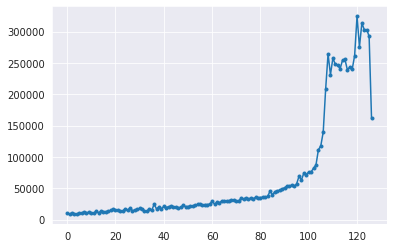

In [12]:
plt.plot(num_edges,marker='.')